In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
if 0:
    !pip install scikit-video==1.1.11
import skvideo.io

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Загрузка и распаковка датасета KTH

In [4]:
# if 1:
#     !wget --no-check-certificate http://www.nada.kth.se/cvap/actions/walking.zip
#     !wget --no-check-certificate http://www.nada.kth.se/cvap/actions/jogging.zip
#     !wget --no-check-certificate http://www.nada.kth.se/cvap/actions/running.zip
#     !wget --no-check-certificate http://www.nada.kth.se/cvap/actions/boxing.zip
#     !wget --no-check-certificate http://www.nada.kth.se/cvap/actions/handwaving.zip
#     !wget --no-check-certificate http://www.nada.kth.se/cvap/actions/handclapping.zip 

# if 1:
#     !unzip walking.zip -d walking > /dev/null
#     !unzip jogging.zip -d jogging > /dev/null
#     !unzip running.zip -d running > /dev/null
#     !unzip boxing.zip -d boxing > /dev/null
#     !unzip handwaving.zip -d handwaving > /dev/null
#     !unzip handclapping.zip -d handclapping > /dev/null

## Подготовка датасета для классификации

In [5]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = 'tkh/'
for cls in classes:
    print(f'Progress_class: {cls}')
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Progress_class: walking
Progress_class: jogging
Progress_class: running
Progress_class: boxing
Progress_class: handwaving
Progress_class: handclapping


In [6]:
# Разделим на тест и трейн 80 на 20
split_percent = 0.7
random.shuffle(dataset)

In [7]:
cut = int(len(dataset) * split_percent)
train, test = dataset[:cut], dataset[cut:]

## Визуализация кадра из видео

In [8]:
! pip install ffmpeg scikit-video

In [9]:
# path_ = 'tkh\handwaving\person08_handwaving_d4_uncomp.avi'

videodata_shape: (950, 120, 160, 3)


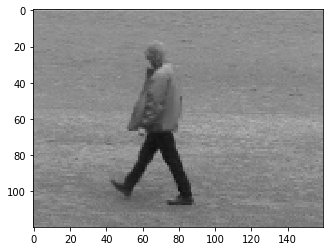

In [10]:
videodata = skvideo.io.vread(dataset[0][0])
# videodata = skvideo.io.vread(path_)
videodata = videodata.astype(np.float32) / 255.
print('videodata_shape:', videodata.shape)
plt.imshow(videodata[50, ...])

## Визуализация "движения"

motion shape: (949, 120, 160, 1)


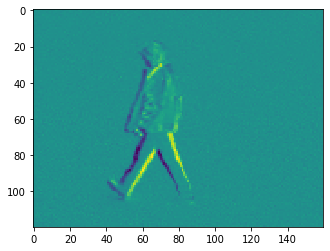

In [11]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

## Создание модели CNN

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(128, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

## Подготовка к обучению

In [13]:
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE)
)

writer = tf.summary.create_file_writer('logs/exp2')

## Цикл обучения модели

In [14]:
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(train):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:1, ...], axis=3, keepdims=True)
        X = motion[None, ...]
        y = np.array(label)[None, ...]
        
        loss_value = model.train_on_batch(X, y)
        
        if iter % 30 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(train)}] Loss = {loss_value}')
            
            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)
        
        global_step +=1


[0/15][0/419] Loss = 1.7873051166534424
[0/15][30/419] Loss = 1.7279033660888672
[0/15][60/419] Loss = 1.758375883102417
[0/15][90/419] Loss = 1.8246636390686035
[0/15][120/419] Loss = 1.6836602687835693
[0/15][150/419] Loss = 1.7842271327972412
[0/15][180/419] Loss = 1.6635743379592896
[0/15][210/419] Loss = 1.8898582458496094
[0/15][240/419] Loss = 1.7029800415039062
[0/15][270/419] Loss = 1.7437214851379395
[0/15][300/419] Loss = 1.8830310106277466
[0/15][330/419] Loss = 1.7219337224960327
[0/15][360/419] Loss = 1.849331021308899
[0/15][390/419] Loss = 1.7683117389678955
[1/15][0/419] Loss = 1.7004033327102661
[1/15][30/419] Loss = 1.787007451057434
[1/15][60/419] Loss = 1.81558358669281
[1/15][90/419] Loss = 1.8718111515045166
[1/15][120/419] Loss = 1.6688988208770752
[1/15][150/419] Loss = 1.7194850444793701
[1/15][180/419] Loss = 1.7856619358062744
[1/15][210/419] Loss = 1.7860019207000732
[1/15][240/419] Loss = 1.7730708122253418
[1/15][270/419] Loss = 1.7510992288589478
[1/15][

[14/15][30/419] Loss = 1.8343853950500488
[14/15][60/419] Loss = 1.7856510877609253
[14/15][90/419] Loss = 1.8343358039855957
[14/15][120/419] Loss = 1.7932080030441284
[14/15][150/419] Loss = 1.8093092441558838
[14/15][180/419] Loss = 1.7701767683029175
[14/15][210/419] Loss = 1.7899208068847656
[14/15][240/419] Loss = 1.7264524698257446
[14/15][270/419] Loss = 1.7204577922821045
[14/15][300/419] Loss = 1.8185569047927856
[14/15][330/419] Loss = 1.7749052047729492
[14/15][360/419] Loss = 1.8534080982208252
[14/15][390/419] Loss = 1.8052361011505127


## TensorBoard

In [46]:
# %load_ext tensorboard
# %tensorboard --logdir logs

## Тестирование обученной модели

In [37]:
test_answers = []
fpath, cls_true = random.choice(test)

for iter, (fpath, label) in enumerate(test):
    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

    out = model(motion[None, ...])[0]
    cls_pred = np.argmax(out.numpy())
    test_answers.append(cls_pred.tolist())


In [20]:
test_label = [label for video, label in test]

In [48]:
from sklearn import metrics
metrics.f1_score(test_label, test_answers, average='weighted')

0.03646170442286947